In [72]:
# import libraries
import os
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [74]:
model = ALS.load("CF.model")

Py4JJavaError: An error occurred while calling o726.load.
: java.lang.NoSuchMethodException: org.apache.spark.ml.recommendation.ALSModel.<init>(java.lang.String)
	at java.lang.Class.getConstructor0(Class.java:3082)
	at java.lang.Class.getConstructor(Class.java:1825)
	at org.apache.spark.ml.util.DefaultParamsReader.load(ReadWrite.scala:333)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [2]:
# list directories
base_dir = '/home/daniellengyel/music-cs182/data/'
triplets_filename = 'train_triplets.txt'

# base_dir2 = '/FileStore/tables/qgz865tr1472080731816/'
# songs2tracks_filename = base_dir2 + 'taste_profile_song_to_tracks.txt'

# base_dir3 = '/FileStore/tables/9204dwdp1472230135186/'
# metadata_filename = base_dir3 + 'track_metadata.csv'

if os.path.sep != '/':
  # Handle Windows.
  triplets_filename = triplets_filename.replace('/', os.path.sep)
#   songs2tracks_filename = songs2tracks_filename.replace('/', os.path.sep)
#   metadata_filename = metadata_filename.replace('/', os.path.sep)
  

In [3]:
# Create schema so the cluster only runs through the data once
plays_df_schema = StructType(
  [StructField('userId', StringType()),
   StructField('songId', StringType()),
   StructField('Plays', IntegerType())]
)

# songs2tracks_df_schema = StructType(
#   [StructField('songId', StringType()),
#    StructField('trackId', StringType())]
# )

# metadata_df_schema = StructType(
#   [StructField('index', IntegerType()),
#    StructField('trackId', StringType()),
#    StructField('title', StringType()),
#    StructField('songId', StringType()),
#    StructField('release', StringType()),
#    StructField('artist_id', StringType()),
#    StructField('artist_mbid', StringType()),
#    StructField('artist_name', StringType()),
#    StructField('duration', DoubleType()),
#    StructField('artist_familiarity', DoubleType()),
#    StructField('artist_hotttness', DoubleType()),
#    StructField('year', IntegerType()),
#    StructField('track_7digitalid', IntegerType()),
#    StructField('shs_perf', DoubleType()),
#    StructField('shs_work', DoubleType())]
# )

# load in data
raw_plays_df = sqlContext.read.format('com.databricks.spark.csv') \
                              .options(delimiter = '\t', header=True,inferSchema=False) \
                              .schema(plays_df_schema) \
                              .load(triplets_filename)

# songs2tracks_df = sqlContext.read.format('com.databricks.spark.csv') \
#                                  .options(delimiter = '\t', header=True,inferSchema=False) \
#                                  .schema(songs2tracks_df_schema) \
#                                  .load(songs2tracks_filename)

# metadata_df = sqlContext.read.format('com.databricks.spark.csv') \
#                              .options(delimiter = ',', header=True,inferSchema=False) \
#                              .schema(metadata_df_schema) \
#                              .load(metadata_filename)

# change ids from strings to integers
userId_change = raw_plays_df.select('userId').distinct().select('userId', F.monotonically_increasing_id().alias('new_userId'))
songId_change = raw_plays_df.select('songId').distinct().select('songId', F.monotonically_increasing_id().alias('new_songId'))

# get total unique users and songs
unique_users = userId_change.count()
unique_songs = songId_change.count()
print('Number of unique users: {0}'.format(unique_users))
print('Number of unique songs: {0}'.format(unique_songs))

# join dataframes
raw_plays_df_with_int_ids = raw_plays_df.join(userId_change, 'userId').join(songId_change, 'songId')

# remove half users to make more manageable
raw_plays_df_with_int_ids = raw_plays_df_with_int_ids.filter(raw_plays_df_with_int_ids.new_userId < unique_users/2)

# cache
raw_plays_df_with_int_ids.cache()
raw_plays_df_with_int_ids.show(5)

# songs2tracks_df.cache()
# songs2tracks_df.show(5)

# metadata_df.cache()
# metadata_df.show(5)

Number of unique users: 1019318
Number of unique songs: 384546
+------------------+--------------------+-----+----------+----------+
|            songId|              userId|Plays|new_userId|new_songId|
+------------------+--------------------+-----+----------+----------+
|SOAAZPG12A6D4F8D8B|bd81df6be2cb9fb3a...|    1|      4970|       116|
|SOAAZPG12A6D4F8D8B|d1202802dc7c346f2...|    1|      5093|       116|
|SOAEBYL12AC468B119|038cd9b57109ec7a3...|    1|       739|       237|
|SOAEBYL12AC468B119|660b60eed2b266be9...|    2|      2607|       237|
|SOAGLII12AB018C1F1|d5bf2cdbb7e42b78e...|    1|      4082|       248|
+------------------+--------------------+-----+----------+----------+
only showing top 5 rows



In [59]:
a = raw_plays_df.select('userId').distinct()

In [60]:
a.show()

+--------------------+
|              userId|
+--------------------+
|3d74b098f9f305180...|
|2712823637478c3c4...|
|9a5a1255c7533ee50...|
|0c473febcbb0cca58...|
|c1abf43a86c0b2661...|
|f33a867d50e03b8bd...|
|4a538227d0e320cdd...|
|f414227ae2726a526...|
|54a414e0f5a9be0f2...|
|39d1abc77c6c37089...|
|2e85b3dbd33613577...|
|6af83028faa5c6b52...|
|d7c67c644e868b1b2...|
|af22da71d5c884e0d...|
|23808f6cb7a787d6c...|
|fbf4b60ede57706dc...|
|1bc3e69923900d8e7...|
|e395a93c707366494...|
|0e41c80fb3c5fe1b7...|
|7f63d6c51b7f7ea73...|
+--------------------+
only showing top 20 rows



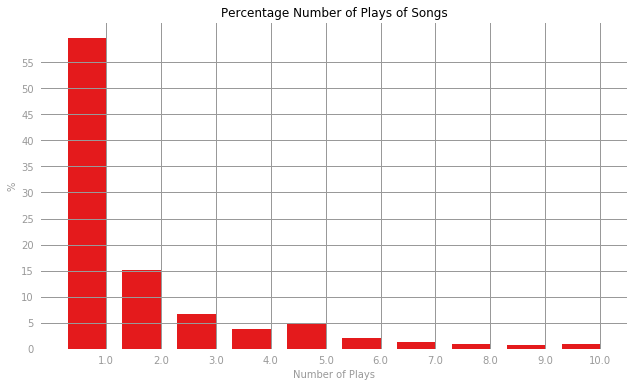

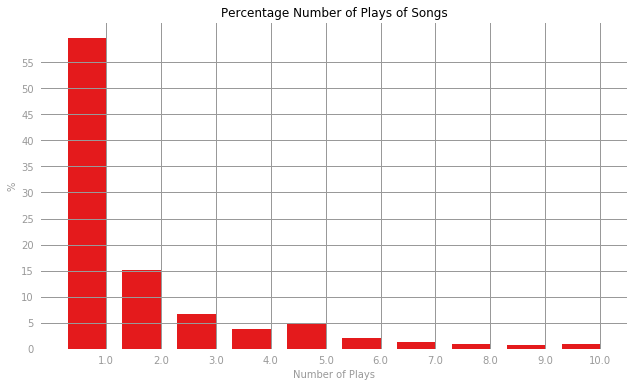

In [20]:
from spark_notebook_helpers import prepareSubplot, np, plt, cm

# count total entries
total_entries = raw_plays_df_with_int_ids.count()

# find percentage listens by number of songs played
number_listens = []
for i in range(10):
    number_listens.append(float(raw_plays_df_with_int_ids.filter(raw_plays_df_with_int_ids.Plays == i+1).count())/total_entries*100)

# create bar plot
bar_width = 0.7
colorMap = 'Set1'
cmap = cm.get_cmap(colorMap)

fig, ax = prepareSubplot(np.arange(0, 10, 1), np.arange(0, 60, 5))
plt.bar(np.linspace(1,10,10), number_listens, width=bar_width, color=cmap(0))
plt.xticks(np.linspace(1,10,10) + bar_width/2.0, np.linspace(1,10,10))
plt.xlabel('Number of Plays'); plt.ylabel('%')
plt.title('Percentage Number of Plays of Songs')
display(fig)
plt.show()


In [43]:
raw_plays_df_with_int_ids_old = raw_plays_df_with_int_ids

In [55]:
raw_plays_df_with_int_ids_old.select('songId').distinct().count()
# raw_plays_df_with_int_ids_old.orderBy("new_userID", ascending=0).show()

74496

In [44]:
raw_plays_df_with_int_ids = raw_plays_df_with_int_ids_old.select("Plays", "new_userId", "new_songId")

In [45]:
# import pyspark.sql.functions.desc

df.orderBy("Plays", ascending=0).limit(80000).count()

80000

In [46]:
# We'll hold out 60% for training, 20% of our data for validation, and leave 20% for testing
seed = 1800009193L
(split_60_df, split_a_20_df, split_b_20_df) = raw_plays_df_with_int_ids.randomSplit([0.6, 0.2, 0.2], seed = seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  training_df.count(), validation_df.count(), test_df.count())
)
training_df.show(3)
validation_df.show(3)
test_df.show(3)

Training: 147311, validation: 49301, test: 49363

+-----+----------+----------+
|Plays|new_userId|new_songId|
+-----+----------+----------+
|    1|        12|       276|
|    1|        38|        43|
|    1|        68|        51|
+-----+----------+----------+
only showing top 3 rows

+-----+----------+----------+
|Plays|new_userId|new_songId|
+-----+----------+----------+
|    1|        47|         7|
|    1|       126|        38|
|    1|       128|       252|
+-----+----------+----------+
only showing top 3 rows

+-----+----------+----------+
|Plays|new_userId|new_songId|
+-----+----------+----------+
|    1|        92|         1|
|    1|       101|       319|
|    1|       146|        22|
+-----+----------+----------+
only showing top 3 rows



In [47]:
#Number of plays needs to be double type, not integers
validation_df = validation_df.withColumn("Plays", validation_df["Plays"].cast(DoubleType()))
validation_df.show(10)

+-----+----------+----------+
|Plays|new_userId|new_songId|
+-----+----------+----------+
|  1.0|        47|         7|
|  1.0|       126|        38|
|  1.0|       128|       252|
|  1.0|       129|        50|
|  1.0|       189|        69|
|  1.0|       191|       167|
|  1.0|       232|         8|
|  1.0|       283|         1|
|  1.0|       300|       130|
|  1.0|       343|       161|
+-----+----------+----------+
only showing top 10 rows



In [48]:
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    """
    grid search function to select the best model based on RMSE of
    validation data
    Parameters
    ----------
    train_data: spark DF with columns ['user', 'song', 'play_count']
    
    validation_data: spark DF with columns ['user', 'song', 'play_count']
    
    maxIter: int, max number of learning iterations
    
    regParams: list of float, one dimension of hyper-param tuning grid
    
    ranks: list of float, one dimension of hyper-param tuning grid
    
    Return
    ------
    The best fitted ALS model with lowest RMSE score on validation data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            # Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
            als = ALS(userCol="new_userId", itemCol="new_songId", ratingCol="Plays", implicitPrefs=True, alpha=40).setMaxIter(maxIter).setRank(rank).setRegParam(reg).setColdStartStrategy("drop")
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)  # give Nan to data that hasn't been seen before. cold_start drops those
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="play_count",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model


In [41]:
sc.setCheckpointDir("checkpoint/")


In [49]:
training_df.show()

+-----+----------+----------+
|Plays|new_userId|new_songId|
+-----+----------+----------+
|    1|        12|       276|
|    1|        38|        43|
|    1|        68|        51|
|    1|        86|       122|
|    1|       110|       693|
|    1|       126|       676|
|    1|       146|       854|
|    1|       149|        31|
|    1|       156|        74|
|    1|       163|       308|
|    1|       172|         8|
|    1|       177|        93|
|    1|       192|       272|
|    1|       202|       653|
|    1|       208|        91|
|    1|       208|       110|
|    1|       232|       167|
|    1|       256|      1066|
|    1|       266|      1082|
|    1|       268|        34|
+-----+----------+----------+
only showing top 20 rows



In [50]:
ranks = [20, 50]
regParams = [0.15, 0.2, 0.25]

model = tune_ALS(training_df, validation_df, 5, regParams, ranks)

Py4JJavaError: An error occurred while calling o458.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 377.0 failed 4 times, most recent failure: Lost task 1.3 in stage 377.0 (TID 9229, m182-better-w-2.c.music182.internal, executor 1): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (bigint) => int)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:211)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: ALS only supports values in Integer range and without fractional part for columns new_userId and new_songId. Value 8589934831 was either out of Integer range or contained a fractional part that could not be converted.
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:96)
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:87)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:931)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:674)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (bigint) => int)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:211)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: ALS only supports values in Integer range and without fractional part for columns new_userId and new_songId. Value 8589934831 was either out of Integer range or contained a fractional part that could not be converted.
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:96)
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:87)
	... 16 more


In [51]:


# Let's initialize our ALS learner
als = ALS()

# Now set the parameters for the method
als.setMaxIter(5)\
   .setSeed(seed)\
   .setItemCol("new_songId")\
   .setRatingCol("Plays")\
   .setUserCol("new_userId")

# Now let's compute an evaluation metric for our test dataset
# We Create an RMSE evaluator using the label and predicted columns
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="Plays", metricName="rmse")

tolerance = 0.03
ranks = [20, 50]
regParams = [0.15, 0.2, 0.25]
errors = [[0]*len(ranks)]*len(regParams)
models = [[0]*len(ranks)]*len(regParams)
err = 0
min_error = float('inf')
best_rank = -1
i = 0
for regParam in regParams:
    j = 0
    for rank in ranks:
        # Set the rank here:
        als.setParams(rank = rank, regParam = regParam)
        # Create the model with these parameters.
        model = als.fit(training_df)
        # Run the model to create a prediction. Predict against the validation_df.
        predict_df = model.transform(validation_df)

        # Remove NaN values from prediction (due to SPARK-14489)
        predicted_plays_df = predict_df.filter(predict_df.prediction != float('nan'))
        predicted_plays_df = predicted_plays_df.withColumn("prediction", F.abs(F.round(predicted_plays_df["prediction"],0)))
        # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
        error = reg_eval.evaluate(predicted_plays_df)
        errors[i][j] = error
        models[i][j] = model
        print 'For rank %s, regularization parameter %s the RMSE is %s' % (rank, regParam, error)
        if error < min_error:
            min_error = error
            best_params = [i,j]
        j += 1
    i += 1

als.setRegParam(regParams[best_params[0]])
als.setRank(ranks[best_params[1]])
print 'The best model was trained with regularization parameter %s' % regParams[best_params[0]]
print 'The best model was trained with rank %s' % ranks[best_params[1]]
my_model = models[best_params[0]][best_params[1]]

Py4JJavaError: An error occurred while calling o545.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 389.0 failed 4 times, most recent failure: Lost task 1.3 in stage 389.0 (TID 9243, m182-better-w-2.c.music182.internal, executor 1): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (bigint) => int)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:211)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: ALS only supports values in Integer range and without fractional part for columns new_userId and new_songId. Value 8589934831 was either out of Integer range or contained a fractional part that could not be converted.
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:96)
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:87)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:931)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:674)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (bigint) => int)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:211)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: ALS only supports values in Integer range and without fractional part for columns new_userId and new_songId. Value 8589934831 was either out of Integer range or contained a fractional part that could not be converted.
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:96)
	at org.apache.spark.ml.recommendation.ALSModelParams$$anonfun$4.apply(ALS.scala:87)
	... 16 more
